In [66]:
import torch
torch.multiprocessing.set_start_method("spawn")        # https://github.com/pytorch/pytorch/issues/3491#event-1326332533
import torch.nn as nn
import torch.optim
from torchvision import datasets,transforms

import numpy as np
import matplotlib
matplotlib.use('Agg')
get_ipython().magic('matplotlib inline')
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplot
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm
import scipy.io

model = 'lenet'
epsilon = 0

RuntimeError: context has already been set

In [67]:
img_channels = 1
if img_channels==3:
    transformImg = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
else:
    transformImg = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize([0.5], [0.5])])
train = datasets.MNIST(root='../data', train=True, download=True, transform=transformImg)
valid = datasets.MNIST(root='../data', train=True, download=True, transform=transformImg)
test = datasets.MNIST(root='../data', train=False, download=True, transform=transformImg)

In [3]:
# create training and validation set indexes (80-20 split)
idx = list(range(len(train)))
np.random.seed(1009)
np.random.shuffle(idx)          
train_idx = idx[ : int(0.8 * len(idx))]       
valid_idx = idx[int(0.8 * len(idx)) : ]

(<matplotlib.axes._subplots.AxesSubplot at 0x7f07a26568d0>,
 <matplotlib.image.AxesImage at 0x7f07a2638dd8>)

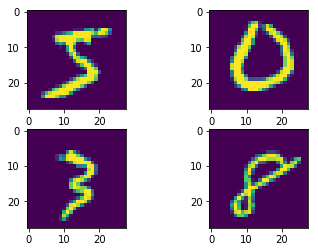

In [69]:
# sample images
fig1 = train.data[0].numpy()  
fig2 = train.data[2500].numpy()
fig3 = train.data[25000].numpy()  
fig4 = train.data[59999].numpy()
subplot(2,2,1), plt.imshow(fig1)  
subplot(2,2,2), plt.imshow(fig2) 
subplot(2,2,3), plt.imshow(fig3)
subplot(2,2,4), plt.imshow(fig4)

In [117]:
import png
_,ix = np.unique(train.targets[:20].numpy(),return_index=True)
for i in range(10):
#     subplot(3,4,i+1)
#     plt.imshow(255-train.data[ix[i]].numpy(),cmap='gray')
#     plt.axis('off')
    
    f = open('mnist%u.png' % i, 'wb')      # binary mode is important
    w = png.Writer(28, 28, greyscale=True)
    w.write(f, 255-train.data[ix[i]].numpy())
    f.close()

In [94]:
# generate training and validation set samples
train_set = torch.utils.data.sampler.SubsetRandomSampler(train_idx)    
valid_set = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)  

# Load training and validation data based on above samples
# Size of an individual batch during training and validation is 30
# Both training and validation datasets are shuffled at every epoch by 'SubsetRandomSampler()'. Test set is not shuffled.
train_loader = torch.utils.data.DataLoader(train, batch_size=30, sampler=train_set, num_workers=4)  
valid_loader = torch.utils.data.DataLoader(train, batch_size=30, sampler=valid_set, num_workers=4)    
test_loader = torch.utils.data.DataLoader(test, num_workers=4)

In [6]:
for batch_num, training_batch in enumerate(train_loader):
    # split training data into inputs and labels
    inputs, labels = training_batch                              # 'training_batch' is a list
    break

torch.Size([30, 1, 28, 28]) torch.Size([30])


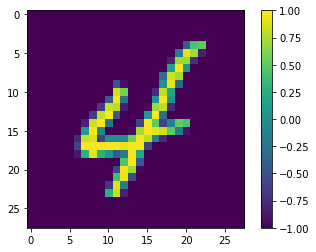

In [7]:
print(inputs.shape,labels.shape)
plt.imshow(inputs[0].squeeze().numpy())
plt.colorbar()

In [8]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# Defining the network (LeNet-5)  
class LeNet5(torch.nn.Module):    
     
    def __init__(self,img_channels=1):
        super(LeNet5, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given as input. Hence padding of 2 is done below)
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) 
        # Fully connected layer
        self.fc1 = nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = nn.Linear(84, 10)        # convert matrix with 84 features to a matrix of 10 features (columns)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxpool1(x) 
        x = torch.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.maxpool2(x)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x = torch.relu(self.fc1(x.view(-1, 16*5*5)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def forward_allout(self, x):
        x1 = torch.relu(self.conv1(x))
        x1 = self.maxpool1(x1)        # max-pooling with 2x2 grid
        x2 = torch.relu(self.conv2(x1))
        x2 = self.maxpool2(x2)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x3 = torch.relu(self.fc1(x2.view(-1, 16*5*5)))
        x4 = torch.relu(self.fc2(x3))
        x5 = self.fc3(x4)
        return x1,x2,x3,x4,x5

# Defining the network (VGG-11, reduced)  
class VGG(torch.nn.Module):          
     
    def __init__(self,img_channels=1):
        super(VGG, self).__init__()
        # Convolution (In VGG, 224x244 images are given as input, but here we use 32x32. Hence padding of 2 is done below)
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2,stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(512, 64) # 64=(3.5*28)^2. following from VGG's 4096=(3.5*224)^2
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxpool1(x)        # max-pooling with 2x2 grid
        x = torch.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.maxpool3(x)
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = self.maxpool3(x)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x = torch.relu(self.fc1(x.view(-1, 512)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def forward_allout(self, x):
        x1 = torch.relu(self.conv1(x))
        x1 = self.maxpool1(x1)        # max-pooling with 2x2 grid
        x2 = torch.relu(self.conv2(x1))
        x2 = self.maxpool2(x2)
        x3 = torch.relu(self.conv3(x2))
        x4 = torch.relu(self.conv4(x3))
        x4 = self.maxpool3(x4)
        x5 = torch.relu(self.conv5(x4))
        x6 = torch.relu(self.conv6(x5))
        x6 = self.maxpool3(x6)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x7 = torch.relu(self.fc1(x6.view(-1, 512)))
        x8 = torch.relu(self.fc2(x7))
        x9 = self.fc3(x8)
        return [x1,x2,x3,x4,x5,x6,x7,x8,x9]


In [9]:
# net = LeNet5(img_channels=img_channels)
if model.lower() == "vgg": net = VGG(img_channels=img_channels)
elif model.lower() == "lenet": net = LeNet5(img_channels=img_channels)
net.cuda()

# set up loss function -- 'SVM Loss' a.k.a 'Cross-Entropy Loss'
loss_func = torch.nn.CrossEntropyLoss()

# SGD used for optimization, momentum update used as parameter update  
optimization = torch.optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)
net

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

inputs, labels = training_batch                              # 'training_batch' is a list
inputs, labels = inputs.to(device), labels.to(device)
if epsilon > 0: inputs.requires_grad = True
# Make gradients zero for parameters 'W', 'b'
net.zero_grad()
# forward, backward pass with parameter update
forward_output = net(inputs)
loss = loss_func(forward_output, labels)
loss.backward()

data_grad = inputs.grad
if epsilon > 0:
    perturbed = fgsm_attack(inputs,epsilon,data_grad).to(device)
    forward_output = net(perturbed)
    loss = loss_func(forward_output, labels)
    loss
    plt.subplot(1,2,1), plt.imshow(inputs[0].squeeze().detach().cpu().numpy())
    plt.subplot(1,2,2), plt.imshow(perturbed[0].squeeze().detach().cpu().numpy())

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Let training begin!
numEpochs = 20    
training_accuracy = []     
validation_accuracy = []

for epoch in range(numEpochs):
    
    # training set -- perform model training
    epoch_training_loss = 0.0
    num_batches = 0
    for batch_num, training_batch in enumerate(train_loader):        # 'enumerate' is a super helpful function        
        # split training data into inputs and labels
        inputs, labels = training_batch                              # 'training_batch' is a list
        inputs, labels = inputs.to(device), labels.to(device)
        if epsilon > 0: inputs.requires_grad = True                  # Necessary for adversarial attack
        # Make gradients zero for parameters 'W', 'b'
        net.zero_grad()
        # forward, backward pass with parameter update
        forward_output = net(inputs)
        loss = loss_func(forward_output, labels)
        loss.backward()
        optimization.step()
        # calculating loss
        epoch_training_loss += loss.item()
        
        # Adversarial attack, if nonzero epsilon provided
        if epsilon > 0:
            data_grad = inputs.grad
            # Adversarial (L-infinity FGSM) attack
            perturbed = fgsm_attack(inputs,epsilon,data_grad).to(device)
            # forward, backward pass with parameter update
            forward_output = net(perturbed)
            loss = loss_func(forward_output, labels)
            loss.backward()
            optimization.step()
            # calculating loss
            epoch_training_loss += loss.item()
        
        num_batches += 1
        
    print("epoch: ", epoch, ", loss: ", epoch_training_loss/num_batches)            
     
    # calculate training set accuracy
    accuracy = 0.0 
    num_batches = 0
    for batch_num, training_batch in enumerate(train_loader):        # 'enumerate' is a super helpful function        
        num_batches += 1
        inputs, actual_val = training_batch
        # perform classification
        predicted_val = net(inputs.cuda())
        # convert 'predicted_val' tensor to numpy array and use 'numpy.argmax()' function    
        predicted_val = predicted_val.cpu().data.numpy()    # convert cuda() type to cpu(), then convert it to numpy
        predicted_val = np.argmax(predicted_val, axis = 1)  # retrieved max_values along every row    
        # accuracy   
        accuracy += accuracy_score(actual_val.numpy(), predicted_val)
    training_accuracy.append(accuracy/num_batches)   

    # calculate validation set accuracy 
    accuracy = 0.0 
    num_batches = 0
    for batch_num, validation_batch in enumerate(valid_loader):        # 'enumerate' is a super helpful function        
        num_batches += 1
        inputs, actual_val = validation_batch
        # perform classification
        predicted_val = net(inputs.cuda())
        # convert 'predicted_val' tensor to numpy array and use 'numpy.argmax()' function    
        predicted_val = predicted_val.cpu().data.numpy()    # convert cuda() type to cpu(), then convert it to numpy
        predicted_val = np.argmax(predicted_val, axis = 1)  # retrieved max_values along every row    
        # accuracy        
        accuracy += accuracy_score(actual_val.numpy(), predicted_val)
    validation_accuracy.append(accuracy/num_batches)

epoch:  0 , loss:  1.2005480212788098
epoch:  1 , loss:  0.1651155644800747
epoch:  2 , loss:  0.11132643846940482
epoch:  3 , loss:  0.08725354678819713
epoch:  4 , loss:  0.07449358925616252
epoch:  5 , loss:  0.06453296684896487
epoch:  6 , loss:  0.05697796066378942
epoch:  7 , loss:  0.051779922650384835
epoch:  8 , loss:  0.047211325001335354
epoch:  9 , loss:  0.04208017934700365
epoch:  10 , loss:  0.038727868630612644
epoch:  11 , loss:  0.03536338231602713
epoch:  12 , loss:  0.03229267020558837
epoch:  13 , loss:  0.02996480069149584
epoch:  14 , loss:  0.0277548289133847
epoch:  15 , loss:  0.025789132779937062
epoch:  16 , loss:  0.02399224320738995
epoch:  17 , loss:  0.021527149596040546
epoch:  18 , loss:  0.01999696401298479
epoch:  19 , loss:  0.01855322842205169


In [14]:
loss.item()

0.003675047541037202

In [15]:
predicted_val = net(inputs.cuda()).cpu().data.numpy()
print(predicted_val[0,:])
predicted_val = np.argmax(predicted_val, axis = 1)
predicted_val

[ -3.6902807  -5.8580637   2.064989   18.416334  -10.629339    3.2851164
  -3.2936337   0.37633     7.8626256  -4.013604 ]


array([3, 6, 8, 9, 2, 6, 4, 8, 1, 3, 6, 7, 3, 5, 0, 8, 4, 3, 8, 4, 2, 2,
       5, 1, 1, 4, 0, 1, 0, 8])

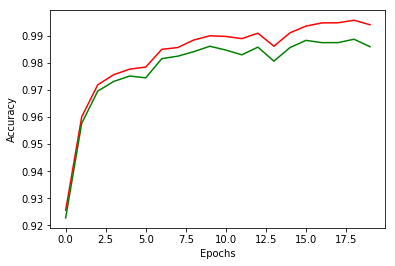

In [16]:
epochs = list(range(numEpochs))

# plotting training and validation accuracies
fig1 = plt.figure()
plt.plot(epochs, training_accuracy, 'r')
plt.plot(epochs, validation_accuracy, 'g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy") 
plt.show(fig1)

In [17]:
# test the model on test dataset
correct = 0
total = 0
for test_data in test_loader:
    total += 1
    inputs, actual_val = test_data 
    # perform classification
    predicted_val = net.forward_allout(inputs.cuda())
    # convert 'predicted_val' GPU tensor to CPU tensor and extract the column with max_score
    predicted_val = predicted_val[-1].cpu().data
    max_score, idx = torch.max(predicted_val, 1)
    # compare it with actual value and estimate accuracy
    correct += (idx == actual_val).sum()
       
print("Classifier Accuracy: ", correct.numpy()/total * 100)

Classifier Accuracy:  98.67


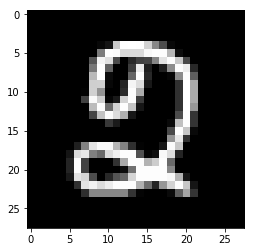

In [45]:
for batch_num, training_batch in enumerate(train_loader):
    # split training data into inputs and labels
    inputs, labels = training_batch                              # 'training_batch' is a list
    break
plt.imshow(inputs[0].squeeze().numpy(), cmap='gray')

(-0.5, 4.5, 4.5, -0.5)

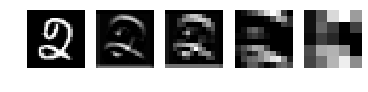

In [60]:
conv1 = torch.relu(net.conv1(inputs.cuda()))
maxpool1 = net.maxpool1(conv1)
conv2 = torch.relu(net.conv2(maxpool1))
maxpool2 = net.maxpool2(conv2)

f=2
subplot(1,5,1), plt.imshow(inputs[0].squeeze().numpy(), cmap='gray'); plt.axis('off')
subplot(1,5,2), plt.imshow(conv1[0,f,:,:].squeeze().detach().cpu().numpy(), cmap='gray'); plt.axis('off')
subplot(1,5,3), plt.imshow(maxpool1[0,f,:,:].squeeze().detach().cpu().numpy(), cmap='gray'); plt.axis('off')
subplot(1,5,4), plt.imshow(conv2[0,f,:,:].squeeze().detach().cpu().numpy(), cmap='gray'); plt.axis('off')
subplot(1,5,5), plt.imshow(maxpool2[0,f,:,:].squeeze().detach().cpu().numpy(), cmap='gray'); plt.axis('off')

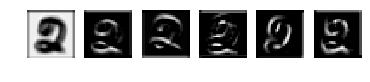

In [130]:
nf = conv1[0,:,:,:].size(0)
for f in range(nf):
    subplot(1,nf,f+1), plt.imshow(conv1[0,f,:,:].squeeze().detach().cpu().numpy(), cmap='gray'); plt.axis('off')

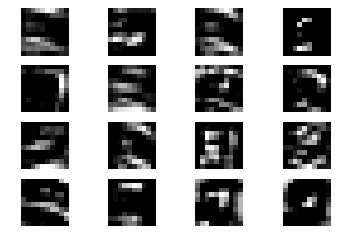

In [132]:
nf = conv2[0,:,:,:].size(0)
for f in range(nf):
    subplot(4,nf/4,f+1), plt.imshow(conv2[0,f,:,:].squeeze().detach().cpu().numpy(), cmap='gray'); plt.axis('off')

(-0.5, 9.5, 29.5, -0.5)

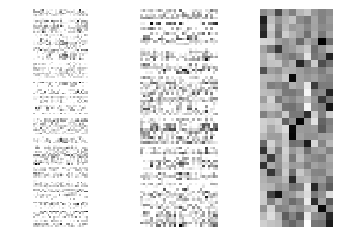

In [68]:
fc1 = torch.relu(net.fc1(maxpool2.view(-1, 16*5*5)))
fc2 = torch.relu(net.fc2(fc1))
fc3 = net.fc3(fc2)

subplot(1,3,1), plt.imshow(-fc1.squeeze().detach().cpu().numpy().T, cmap='gray'); plt.axis('off')
subplot(1,3,2), plt.imshow(-fc2.squeeze().detach().cpu().numpy().T, cmap='gray'); plt.axis('off')
subplot(1,3,3), plt.imshow(-fc3.squeeze().detach().cpu().numpy(), cmap='gray'); plt.axis('off')

In [17]:
# testout = net.forward_allout(test.data[0].cuda().view(1,1,28,28))
testout1 = net.forward_allout(inputs.cuda())
# x1.shape,x2.shape,x3.shape,x4.shape,x5.shape
# (0,)+tuple(testout1[0].shape[1:])
out=list()
for i in range(len(testout1)):
    out.append(torch.zeros(size=(len(test_loader),)+tuple(testout1[i].shape[1:])))
    print(out[i].shape)

torch.Size([10000, 6, 14, 14])
torch.Size([10000, 16, 5, 5])
torch.Size([10000, 120])
torch.Size([10000, 84])
torch.Size([10000, 10])


In [18]:
test.data.view(-1,1,28,28).cuda().size()

torch.Size([10000, 1, 28, 28])

In [19]:
#testout[0].shape
torch.cat((testout1[0],testout1[0])).shape

torch.Size([2, 6, 14, 14])

In [20]:
# this will run out of memory
#testout = net.forward_allout(test.data.view(-1,1,28,28).to(device=device, dtype=torch.float))
# with tqdm(total=len(test_loader)) as pbar:
s=0
for test_data in test_loader:
    inputs, actual_val = test_data    
    tmp = net.forward_allout(inputs.to(device=device, dtype=torch.float))
    for i in range(len(tmp)):
        out[i][s,:] = tmp[i].detach().cpu()
#         pbar.update(1)
    s+=1
    if s % 1000 == 0: print(s)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [21]:
out[-1].size()

torch.Size([10000, 10])

(tensor([ 16.6975, -10.3811, -25.3720, -11.8027,   5.9252,   2.4280,  35.6763,
         -14.2460,   1.2245,   0.3684]), 6)

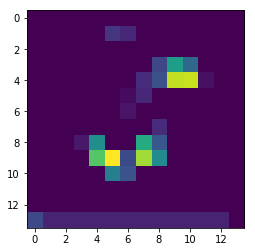

In [22]:
inum=66
plt.imshow(out[0][inum,0,:,:].squeeze().detach().cpu().numpy())
out[-1][inum],np.argmax(out[-1][inum].detach().cpu().numpy())

In [23]:
## SAVE DATA FOR MATLAB
savedict = {}
keys = range(len(out))
for i in keys:
    savedict['x'+str(i+1)] = out[i].detach().cpu().numpy()
savedict['labels'] = test.targets.detach().cpu().numpy()

savefile = "mnist_%s_eps%.2f.mat" % (model.lower(),epsilon)
scipy.io.savemat(savefile,savedict)